# Testing Out Support Vector Regression

## Importing Necessary Libraries

In [43]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## Loading in the Dataset

In [44]:
csv_url = 'https://gist.github.com/NickyDCFP/d675b176350f6a1d54455ffc35e350f9/raw/' + \
          '220fdbc2aec82b8b3e33681e4465813c02b5fccf/Spotify_Youtube.csv'
csv_df = pd.read_csv(csv_url)
# This column may not be necessary (duplicate of index), may remove
csv_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
csv_df.head()

,ID,Artist,Url_spotify,Track,Album,Album_type,Uri,Danceability,Energy,Key,...,Url_youtube,Title,Channel,Views,Likes,Comments,Description,Licensed,official_video,Stream
0,0,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Feel Good Inc.,Demon Days,album,spotify:track:0d28khcov6AiegSCpG5TuT,0.818,0.705,6.0,...,https://www.youtube.com/watch?v=HyHNuVaZJ-k,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,Official HD Video for Gorillaz' fantastic trac...,True,True,1.040235e+09
1,1,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Rhinestone Eyes,Plastic Beach,album,spotify:track:1foMv2HQwfQ2vntFf9HFeG,0.676,0.703,8.0,...,https://www.youtube.com/watch?v=yYDmaexVHic,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,The official video for Gorillaz - Rhinestone E...,True,True,3.100837e+08
2,2,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,spotify:track:64dLd6rVqDLtkXFYrEUHIU,0.695,0.923,1.0,...,https://www.youtube.com/watch?v=qJa-VFwPpYA,Gorillaz - New Gold ft. Tame Impala & Bootie B...,Gorillaz,8435055.0,282142.0,7399.0,Gorillaz - New Gold ft. Tame Impala & Bootie B...,True,True,6.306347e+07
3,3,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,On Melancholy Hill,Plastic Beach,album,spotify:track:0q6LuUqGLUiCPP1cbdwFs3,0.689,0.739,2.0,...,https://www.youtube.com/watch?v=04mfKJWDSzI,Gorillaz - On Melancholy Hill (Official Video),Gorillaz,211754952.0,1788577.0,55229.0,Follow Gorillaz online:\nhttp://gorillaz.com \...,True,True,4.346636e+08
4,4,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Clint Eastwood,Gorillaz,album,spotify:track:7yMiX7n9SBvadzox8T5jzT,0.663,0.694,10.0,...,https://www.youtube.com/watch?v=1V_xRb0x9aw,Gorillaz - Clint Eastwood (Official Video),Gorillaz,618480958.0,6197318.0,155930.0,The official music video for Gorillaz - Clint ...,True,True,6.172597e+08


In [45]:
irrelevant_columns = ["Url_spotify", "Uri", "Url_youtube", "ID", "Artist", "Track", "Album", "Album_type", "Title", "Channel", "Description", 'Licensed', 'official_video'] # For now, dropping all non-numeric columns
df = csv_df.drop(irrelevant_columns, axis=1)
df.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
0,0.818,0.705,6.0,-6.679,0.1770,0.008360,0.002330,0.6130,0.772,138.559,222640.0,693555221.0,6220896.0,169907.0,1.040235e+09
1,0.676,0.703,8.0,-5.815,0.0302,0.086900,0.000687,0.0463,0.852,92.761,200173.0,72011645.0,1079128.0,31003.0,3.100837e+08
2,0.695,0.923,1.0,-3.930,0.0522,0.042500,0.046900,0.1160,0.551,108.014,215150.0,8435055.0,282142.0,7399.0,6.306347e+07
3,0.689,0.739,2.0,-5.810,0.0260,0.000015,0.509000,0.0640,0.578,120.423,233867.0,211754952.0,1788577.0,55229.0,4.346636e+08
4,0.663,0.694,10.0,-8.627,0.1710,0.025300,0.000000,0.0698,0.525,167.953,340920.0,618480958.0,6197318.0,155930.0,6.172597e+08


In [46]:
y_cols = ['Views', 'Likes', 'Comments']
df = df.dropna()
df = df.loc[df['Views'] != 0]
num_likes = np.array(df['Likes']).astype(int)
num_comments = np.array(df['Comments']).astype(int)
num_views = np.array(df['Views']).astype(int)

In [112]:
X_df = df.drop(y_cols, axis=1)
X = np.array(X_df).astype('float32')
y = (num_likes / num_views).astype('float32') # Can also use comment proportion as target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
clf = IsolationForest()
clf.fit(X_train)
y_p = clf.predict(X_train)
X_train = X_train[y_p == 1, :]
y_train = y_train[y_p == 1]
y_p_test = clf.predict(X_test)
X_test = X_test[y_p_test == 1, :]
y_test = y_test[y_p_test == 1]
print(X_train.shape)

(8579, 12)


In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [113]:
model = SVR(kernel='poly', C=100, epsilon=0.2)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_train)

In [114]:
loss = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print(f'MSE: {loss}\nR^2:{r2}')

MSE: 0.010248544778123463
R^2:-79.98378145985276


In [51]:
def try_test_size(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = SVR(kernel='poly', C=100)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)
    train_loss = mean_squared_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    test_loss = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    return {'test_size': test_size, 'loss': train_loss, 'r2': train_r2}, \
           {'test_size': test_size, 'loss': test_loss, 'r2': test_r2}

In [52]:
cols = ['test_size', 'loss', 'r2']
training_error = pd.DataFrame(columns=cols)
test_error = pd.DataFrame(columns=cols)

for i in range(1, 50, 1):
    test_size = i / 100
    history, eval = try_test_size(X, y, test_size)
    training_error = pd.concat([training_error, pd.DataFrame(history, index=['test_size'])], ignore_index=True)
    test_error = pd.concat([test_error, pd.DataFrame(eval, index=['test_size'])], ignore_index=True)

display(training_error.head())
display(test_error.head())

,test_size,loss,r2
0,0.01,0.004747,-36.442872
1,0.02,0.004757,-36.366163
2,0.03,0.004763,-36.328054
3,0.04,0.004930,-37.513517
4,0.05,0.004935,-37.511413


,test_size,loss,r2
0,0.01,0.004778,-45.953643
1,0.02,0.004776,-52.467682
2,0.03,0.004818,-51.010331
3,0.04,0.004999,-53.676539
4,0.05,0.008292,-85.171640


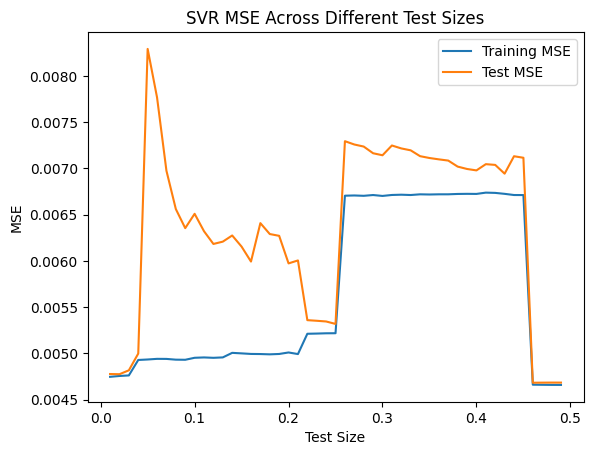

In [53]:
plt.figure()
plt.plot(training_error['test_size'], training_error['loss'], label='Training MSE')
plt.plot(test_error['test_size'], test_error['loss'], label='Test MSE')
plt.title('SVR MSE Across Different Test Sizes')
plt.xlabel('Test Size')
plt.ylabel('MSE')
plt.legend()
plt.show()

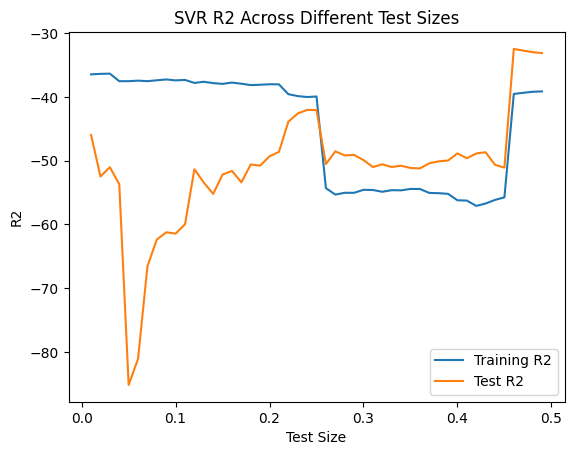

In [54]:
plt.figure()
plt.plot(training_error['test_size'], training_error['r2'], label='Training R2')
plt.plot(test_error['test_size'], test_error['r2'], label='Test R2')
plt.title('SVR R2 Across Different Test Sizes')
plt.xlabel('Test Size')
plt.ylabel('R2')
plt.legend()
plt.show()

In [60]:
def try_kernels(X, y, C_arr):
    kernel_df = pd.DataFrame(columns=['C', 'Linear Kernel Loss', 'Linear Kernel R2', 'Polynomial Kernel Loss', 'Polynomial Kernel R2', 'RBF Kernel Loss', 'RBF Kernel R2'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    scaler = StandardScaler()
    clf = IsolationForest()
    clf.fit(X_train)
    y_p = clf.predict(X_train)
    X_train = X_train[y_p == 1, :]
    y_train = y_train[y_p == 1]
    y_p_test = clf.predict(X_test)
    X_test = X_test[y_p_test == 1, :]
    y_test = y_test[y_p_test == 1]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    for i, C in enumerate(C_arr):
        model_lin = SVR(kernel='linear',C=C)
        model_poly = SVR(kernel='poly', C=C, degree=3)
        model_rbf = SVR(kernel='rbf', C=C, gamma=0.1)
        a = model_lin.fit(X_train_scaled, y_train)
        b = model_poly.fit(X_train_scaled, y_train)
        c = model_rbf.fit(X_train_scaled, y_train)
        y_pred_lin = a.predict(X_test_scaled)
        y_pred_poly = b.predict(X_test_scaled)
        y_pred_rbf = c.predict(X_test_scaled)
        r2_lin = r2_score(y_test, y_pred_lin)
        loss_lin = mean_squared_error(y_pred_lin, y_test)
        r2_poly = r2_score(y_test, y_pred_poly)
        loss_poly = mean_squared_error(y_pred_poly, y_test)
        r2_rbf = r2_score( y_test, y_pred_rbf)
        loss_rbf = mean_squared_error(y_pred_rbf, y_test)
        kernel_df.loc[i] = [C, loss_lin, r2_lin, loss_poly, r2_poly, loss_rbf, r2_rbf]
    return kernel_df

In [61]:
C_arr = [1e-7, 1e-6, 1e-3, 0.01, 0.1, 1, 2, 5, 10, 100, 1000]
kernel_df = try_kernels(X, y, C_arr)
kernel_df

,C,Linear Kernel Loss,Linear Kernel R2,Polynomial Kernel Loss,Polynomial Kernel R2,RBF Kernel Loss,RBF Kernel R2
0,1.000000e-07,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
1,1.000000e-06,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
2,1.000000e-03,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
3,1.000000e-02,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
4,1.000000e-01,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
5,1.000000e+00,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
6,2.000000e+00,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
7,5.000000e+00,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
8,1.000000e+01,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
9,1.000000e+02,0.005377,-39.682722,0.005377,-39.682722,0.005377,-39.682722
